In [11]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import squidpy as sq
from sklearn.metrics.pairwise import cosine_similarity
import statistics
import pandas as pd
import json

In [12]:
cell2loc_results = sc.read_h5ad("results/cell2location_map/sp.h5ad") #read cell2loc results

In [13]:
#cell2loc_results.obsm["means_cell_abundance_w_sf"]
max_values = cell2loc_results.obsm["means_cell_abundance_w_sf"].max(axis=1)
print("MAX values row-wise:", max_values)

#cell2loc_results.obsm["means_cell_abundance_w_sf"]
sum_values = cell2loc_results.obsm["means_cell_abundance_w_sf"].sum(axis=1)
print("SUM values row-wise:", sum_values)


MAX values row-wise: AAATGGCATGTCTTGT-1     4.823495
AACAACTGGTAGTTGC-1     5.637232
AACAGGAAATCGAATA-1    10.692219
AACCCAGAGACGGAGA-1     5.302188
AACCGTTGTGTTTGCT-1     5.510438
                        ...    
TTGGATTGGGTACCAC-1     5.376845
TTGGCTCGCATGAGAC-1    16.993872
TTGTATCACACAGAAT-1     9.417141
TTGTGGCCCTGACAGT-1     8.614881
TTGTTAGCAAATTCGA-1    11.993877
Length: 324, dtype: float32
SUM values row-wise: AAATGGCATGTCTTGT-1    26.143202
AACAACTGGTAGTTGC-1    30.413691
AACAGGAAATCGAATA-1    38.618855
AACCCAGAGACGGAGA-1    23.064905
AACCGTTGTGTTTGCT-1    24.742737
                        ...    
TTGGATTGGGTACCAC-1    28.139208
TTGGCTCGCATGAGAC-1    39.781921
TTGTATCACACAGAAT-1    40.918724
TTGTGGCCCTGACAGT-1    32.718231
TTGTTAGCAAATTCGA-1    37.988155
Length: 324, dtype: float32


In [14]:
cell2loc_matrix = cell2loc_results.obsm["means_cell_abundance_w_sf"] #get cell2location results

cell2loc_matrix = cell2loc_matrix.T  #transpose matrix so I can compare to tg

cell2loc_dist = cell2loc_matrix.div(cell2loc_matrix.sum(axis=0), axis=1) #normalize so each row sums up to 1


In [15]:
#tg_dist = np.loadtxt("tg_ct_dist.txt") #load tg results
tg_dist = np.loadtxt("tg_ct_dist_no_thresh.txt") #load tg results


In [16]:
tg_dist.shape == cell2loc_dist.shape

True

In [17]:
tg = tg_dist  # already a NumPy array
c2l = cell2loc_dist.values  # convert pandas DataFrame to NumPy

# Similarity per spot (column-wise comparison)
similarity = [
    cosine_similarity(tg[:, [i]].T, c2l[:, [i]].T)[0, 0]
    for i in range(tg.shape[1])
]

correlations = [
    np.corrcoef(tg[:, i], c2l[:, i])[0, 1]
    for i in range(tg.shape[1])
]

(array([ 1., 10., 26., 26., 52., 70., 51., 46., 38.,  4.]),
 array([0.24073649, 0.28610623, 0.33147596, 0.3768457 , 0.42221543,
        0.46758517, 0.5129549 , 0.55832464, 0.60369437, 0.64906411,
        0.69443384]),
 <BarContainer object of 10 artists>)

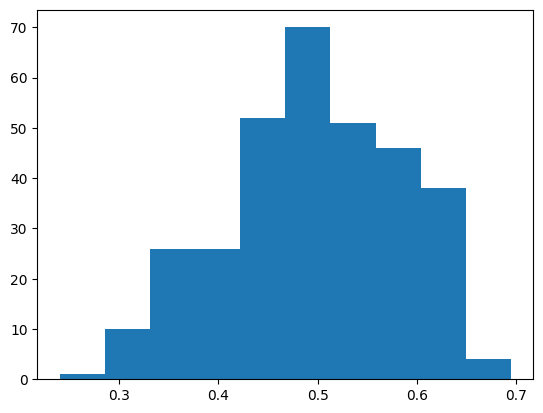

In [18]:
plt.hist(similarity)

(array([ 3.,  5., 19., 53., 72., 73., 42., 32., 23.,  2.]),
 array([-0.10853565, -0.05097835,  0.00657896,  0.06413626,  0.12169356,
         0.17925087,  0.23680817,  0.29436547,  0.35192278,  0.40948008,
         0.46703739]),
 <BarContainer object of 10 artists>)

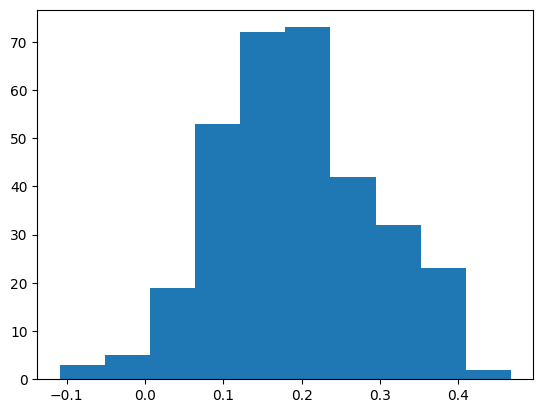

In [19]:
plt.hist(correlations)

/tmp/ipykernel_2507918/1883001416.py:5: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


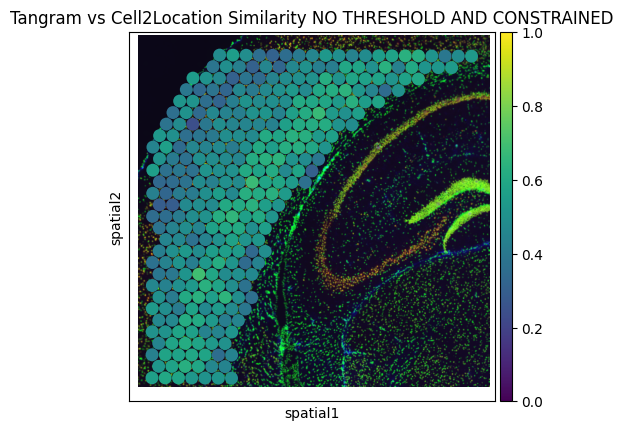

In [22]:
# Add similarity metric as a new column in .obs
cell2loc_results.obs['tg_vs_c2l_similarity'] = similarity  # or correlations

# Plot over tissue
sc.pl.spatial(
    cell2loc_results,
    color='tg_vs_c2l_similarity',
    cmap='viridis',
    size=1.5,
    title="Tangram vs Cell2Location Similarity NO THRESHOLD AND CONSTRAINED",
    vmin=0,
    vmax=1
)

# Looking at Black spots

In [21]:
black_spot_index = similarity.index(min(similarity))

print(tg[:, black_spot_index])
print(c2l[:, black_spot_index])
print(tg[:, black_spot_index] - c2l[:, black_spot_index])

statistics.fmean(similarity)

[0.100196 0.063318 0.122655 0.040116 0.080073 0.030019 0.112714 0.132487
 0.009439 0.063085 0.112235 0.010654 0.004298 0.044269 0.024694 0.021586
 0.008227 0.001336 0.001644 0.006615 0.001176 0.004862 0.004303]
[0.02074265 0.18058506 0.00695091 0.51739377 0.01922226 0.00313545
 0.00377929 0.00260289 0.00403885 0.00323497 0.00473396 0.03329785
 0.03650109 0.00155911 0.00758616 0.00703375 0.01658014 0.00284081
 0.02887462 0.01677839 0.00552978 0.00401138 0.07298678]
[ 0.07945335 -0.11726706  0.11570409 -0.47727777  0.06085074  0.02688355
  0.10893471  0.12988411  0.00540015  0.05985003  0.10750104 -0.02264385
 -0.03220309  0.04270989  0.01710784  0.01455225 -0.00835314 -0.00150481
 -0.02723062 -0.01016339 -0.00435378  0.00085062 -0.06868378]


0.49650397498555787

In [38]:
thresh_sim = sorted(similarity)[9]

indices = np.where(similarity <= thresh_sim)[0]
print(indices)

[  7  11  28  46  68 189 205 229 315 318]


# Cell2location ct distribution

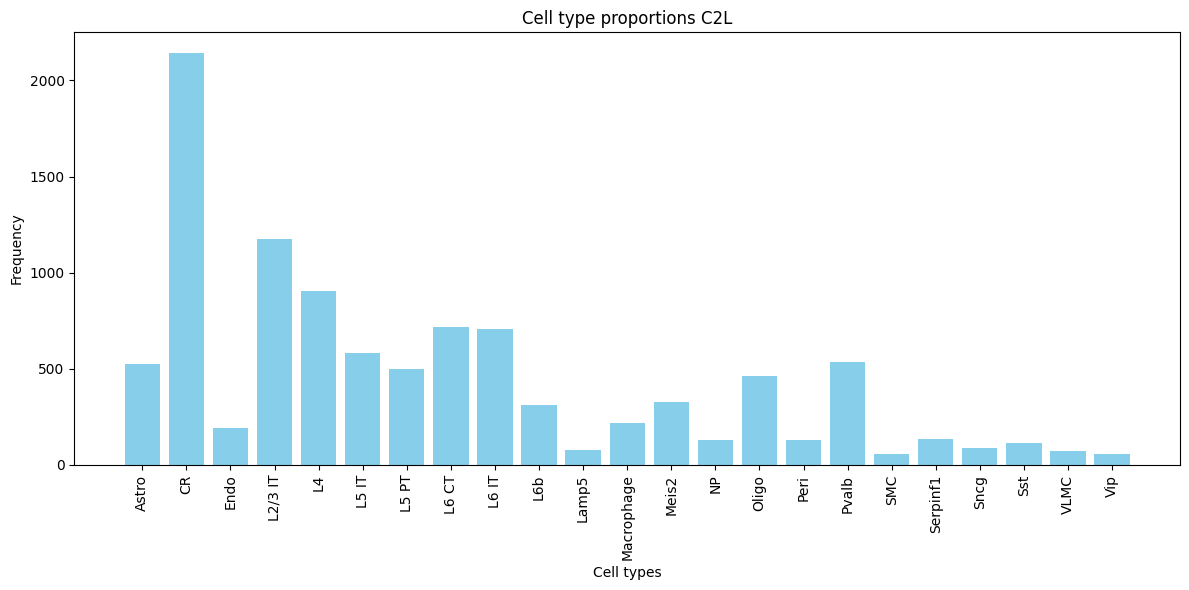

In [5]:
cell_abundance = cell2loc_results.obsm['means_cell_abundance_w_sf'] #c2l results

cell_abundance_df = pd.DataFrame( # Convert to DataFrame for easy handling (optional but useful)
    cell_abundance, 
    index=cell2loc_results.obs_names, 
    columns=cell2loc_results.obsm['means_cell_abundance_w_sf'].dtype.names 
    if hasattr(cell2loc_results.obsm['means_cell_abundance_w_sf'], 'dtype') else cell2loc_results.obsm['means_cell_abundance_w_sf'].columns
)


# UNCOMMENT FOR PROBABILITY DISTRIBUTION (L1 NORMALIZATION)

cell_type_totals = cell_abundance_df.sum(axis=0) #get total abundance per ct

cell_type_totals = cell_type_totals.sort_index() #sort descending

#cell_type_totals /= cell_type_totals.sum() #compute proportions

cell_type_totals.index = cell_type_totals.index.str.split('_fg_').str[-1]



# Plot
plt.figure(figsize=(12, 6))
plt.bar(cell_type_totals.index, cell_type_totals.values, color='skyblue')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel('Cell types')
plt.ylabel('Frequency')
plt.title('Cell type proportions C2L')
plt.tight_layout()
plt.show()



# Comparing sc and c2l proportions 

In [45]:
with open('ct_abundance_sc.json', 'r') as f:
    sc_abundance = json.load(f)

sc_abundance = dict(sorted(sc_abundance.items()))


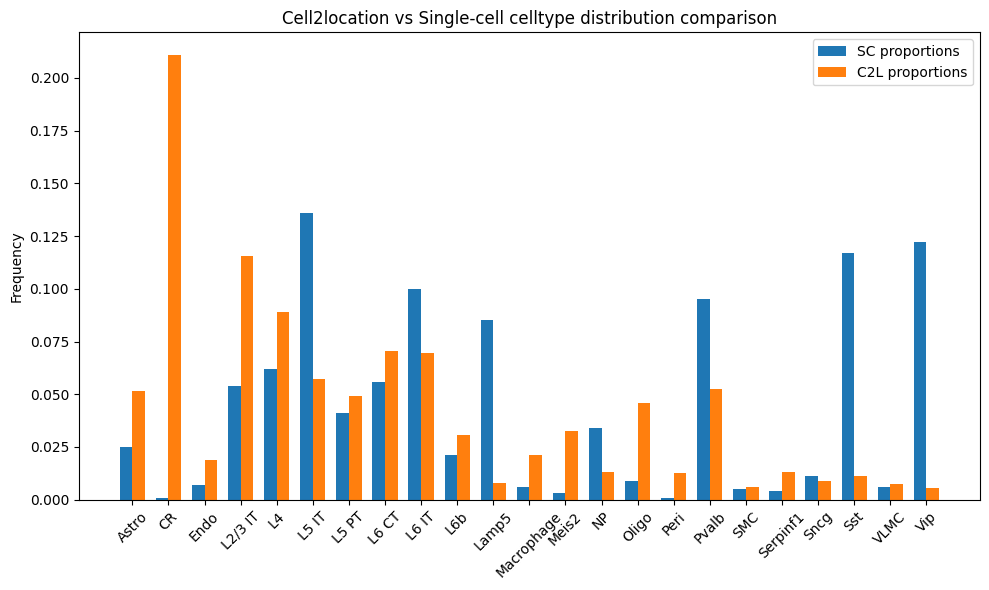

In [51]:
categories = list(sc_abundance.keys())

x = np.arange(len(categories))                 # The label locations
width = 0.35                                   # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, list(sc_abundance.values()), width, label='SC proportions')
bars2 = ax.bar(x + width/2, cell_type_totals.values, width, label='C2L proportions')

# Labels, title and custom x-axis tick labels
ax.set_ylabel('Frequency')
ax.set_title('Cell2location vs Single-cell celltype distribution comparison')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()


# Comparing sc and c2l proportions RAW

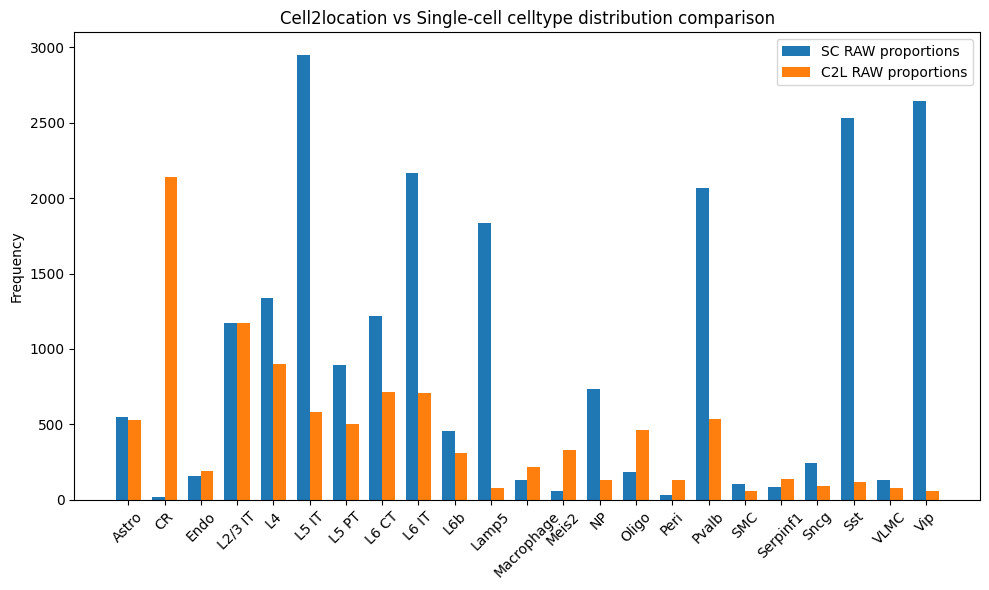

In [21]:
with open('ct_abundance_sc_RAW.json', 'r') as f:
    sc_abundance = json.load(f) #load sc ct raw counts

sc_abundance = dict(sorted(sc_abundance.items())) #sort sc ct raw counts

categories = list(sc_abundance.keys()) #get celltypes

x = np.arange(len(categories))                 # The label locations
width = 0.35                                   # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, list(sc_abundance.values()), width, label='SC RAW proportions')
bars2 = ax.bar(x + width/2, cell_type_totals.values, width, label='C2L RAW proportions')

# Labels, title and custom x-axis tick labels
ax.set_ylabel('Frequency')
ax.set_title('Cell2location vs Single-cell celltype distribution comparison')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

In [20]:
print("Total cells in sc:", sum(sc_abundance.values()))
print("Total cells estimated by C2L:", sum(cell_type_totals.values))

Total cells in sc: 21697
Total cells estimated by C2L: 10153.681


In [19]:
print(sum(cell_type_totals.values))

10153.681
